In [1]:
from collections import Counter
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import torch

# 1. Data Preparation

### Loading Data

In [3]:
# Loading data into pandas dataframes
data_lrt = pd.read_csv("Data/data_lrt.csv", index_col=0)
data_15min = pd.read_csv("Data/data_15min.csv", index_col=0)

In [4]:
data_lrt.head()

,source,category,date,title,score,last_updated
0,lrt.lt,lietuvoje,2022-04-09,penkiu vaiku mama pasigenda valstybes pagalbos...,0,2022-04-09
1,lrt.lt,lietuvoje,2022-04-09,simasius tikisi kad pamokos ukrainietiskai vil...,0,2022-04-09
2,lrt.lt,lietuvoje,2022-04-09,naujausios apklausos neaiski pozicija del vers...,0,2022-04-09
3,lrt.lt,lietuvoje,2022-04-09,kyjive irpineje bucoje apsilanke parlamentarai...,0,2022-04-09
4,lrt.lt,lietuvoje,2022-04-09,per para lietuvoje 1750 koronaviruso atvejai m...,47,2022-04-09


In [5]:
data_15min.head()

,source,category,date,title,score,last_updated
0,15min.lt,lietuvoje,2022-04-12,lietuvos seime volodymyro zelenskio kalba,0,2022-04-12
1,15min.lt,lietuvoje,2022-04-12,vsd isaugo rizika keliaujantiems i rusija ir b...,0,2022-04-12
2,15min.lt,lietuvoje,2022-04-12,a sirinskiene pataisos leis georgijaus juosta ...,0,2022-04-12
3,15min.lt,lietuvoje,2022-04-12,siemet vvkt gavo 1151 pranesimu apie nepageida...,0,2022-04-12
4,15min.lt,lietuvoje,2022-04-12,dirbanciu neigaliuju asociacija reforma del ne...,0,2022-04-12


In [6]:
print(f"lrt.lt:{data_lrt.shape[0]}, 15min.lt:{data_15min.shape[0]}")

lrt.lt:133437, 15min.lt:72107


- Both tables have source, category, date, title, score and last_updated columns.
- There are 133437 entries from lrt.lt data and 72107 entries from 15min.lt

In [7]:
# Joining both dataframes
df = pd.concat([data_lrt, data_15min]).reset_index(drop=True)
df

,source,category,date,title,score,last_updated
0,lrt.lt,lietuvoje,2022-04-09,penkiu vaiku mama pasigenda valstybes pagalbos...,0,2022-04-09
1,lrt.lt,lietuvoje,2022-04-09,simasius tikisi kad pamokos ukrainietiskai vil...,0,2022-04-09
2,lrt.lt,lietuvoje,2022-04-09,naujausios apklausos neaiski pozicija del vers...,0,2022-04-09
3,lrt.lt,lietuvoje,2022-04-09,kyjive irpineje bucoje apsilanke parlamentarai...,0,2022-04-09
4,lrt.lt,lietuvoje,2022-04-09,per para lietuvoje 1750 koronaviruso atvejai m...,47,2022-04-09
...,...,...,...,...,...,...
205539,15min.lt,maistas,2021-03-16,iki lojaliems klientams skelbia akcija apdorot...,0,2022-04-12
205540,15min.lt,maistas,2021-03-12,savaitgalio pietums gardus lasisos kepsneliai ...,0,2022-04-12
205541,15min.lt,maistas,2021-03-12,zemes heroju testas ar susimastete koks jusu p...,0,2022-04-12
205542,15min.lt,maistas,2021-03-12,ruosiames velykoms trys paprastos ir gardzios ...,0,2022-04-12


### Changing data types and converting categories

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205544 entries, 0 to 205543
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   source        205544 non-null  object
 1   category      205544 non-null  object
 2   date          205544 non-null  object
 3   title         205544 non-null  object
 4   score         205544 non-null  int64 
 5   last_updated  205544 non-null  object
dtypes: int64(1), object(5)
memory usage: 9.4+ MB


##### No columns have missing values but source, category, date and last_updated columns have incorrect data types

In [8]:
# Changing columns' data types
df["source"] = df["source"].astype("category")
df["category"] = df["category"].astype("category")
df["date"] = pd.to_datetime(df["date"])
df["last_updated"] = pd.to_datetime(df["last_updated"])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205544 entries, 0 to 205543
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   source        205544 non-null  category      
 1   category      205544 non-null  category      
 2   date          205544 non-null  datetime64[ns]
 3   title         205544 non-null  object        
 4   score         205544 non-null  int64         
 5   last_updated  205544 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), int64(1), object(1)
memory usage: 6.7+ MB


##### Now all columns have correct data types

In [10]:
# Converting categories
# "pozicija" category only exists in lrt.lt website and it's structure is the same as "nuomones" category, so it is converted to
# "nuomones category"
df.loc[df["category"]=="pozicija", "category"] = "nuomones"

# "lrt-tyrimai" category only exists in lrt.lt website and it's structure is similar to "kriminalai" category from 15min.lt
# website, so it is converted to "kriminalai" category
df.loc[df["category"]=="lrt-tyrimai", "category"] = "kriminalai"

df["category"] = df["category"].cat.remove_categories(["pozicija", "lrt-tyrimai"])

In [11]:
df["category"].unique().to_list(), len(df["category"].unique().to_list())

(['lietuvoje',
  'nuomones',
  'pasaulyje',
  'verslas',
  'kriminalai',
  'eismas',
  'sportas',
  'sveikata',
  'mokslas-ir-it',
  'kultura',
  'veidai',
  'gyvenimas',
  'tavo-lrt',
  'muzika',
  'maistas'],
 15)

##### There are 15 categories now

In [12]:
# For this project only two columns will be needed: category and title
df_cat = df.copy()[["category", "title"]]
df_cat.head()

,category,title
0,lietuvoje,penkiu vaiku mama pasigenda valstybes pagalbos...
1,lietuvoje,simasius tikisi kad pamokos ukrainietiskai vil...
2,lietuvoje,naujausios apklausos neaiski pozicija del vers...
3,lietuvoje,kyjive irpineje bucoje apsilanke parlamentarai...
4,lietuvoje,per para lietuvoje 1750 koronaviruso atvejai m...


### Removing title duplicates and keeping categories of interest

In [13]:
def keep_rare_duplicates(df):
    """Remove duplicated titles while keeping the less popular category"""
    # Calculating the number of titles for every category in a dataframe
    sorted_cat = list(df["category"].value_counts().sort_values(ascending=True).index)
    cat_num = {}
    for num, cat in enumerate(sorted_cat):
        cat_num[cat] = num
    
    # Finding duplicated titles
    duplicated_titles = df[df.duplicated("title")]["title"].values
    
    # If title was put in different categories, keeping the less popular one
    for t in duplicated_titles:
        smaller_cat = None
        rows = df[df["title"] == t]["category"]
        indexes = list(rows.index)
        categories = list(rows.values)
        for c in categories:
            if not smaller_cat:
                smaller_cat = c
            else:
                if cat_num[c] < cat_num[smaller_cat]:
                    smaller_cat = c
        df.loc[indexes, "category"] = smaller_cat
    
    return df[~df.duplicated("title")].reset_index(drop=True)  # Fully removing duplicates

In [14]:
def remove_title_duplicates_set_categories(df, cat_to_keep):
    """Only keep categories of interest and remove duplicated titles"""
    # Keeping categories of interest
    df["category"] = df["category"].cat.set_categories(cat_to_keep)
    df = df.dropna()
    
    # Droping absolute duplicates
    df = df[~df.duplicated(["category", "title"])].reset_index(drop=True)
    
    # Changing remaining duplicates' categories to the ones that are less popular in the dataframe
    df = keep_rare_duplicates(df)
    
    return df

In [15]:
# Number of titles for each category
df_cat["category"].value_counts()

verslas          30393
lietuvoje        25019
pasaulyje        24454
sportas          16576
kultura          15566
gyvenimas        15453
mokslas-ir-it    13959
nuomones         13855
eismas           12015
tavo-lrt         11214
veidai           11214
kriminalai        6616
sveikata          5093
muzika            3997
maistas            120
Name: category, dtype: int64

In [16]:
# Choosing which categories to keep
categories_to_keep = ["verslas", "sportas", "kultura", "mokslas-ir-it",
                      "nuomones", "eismas", "kriminalai", "sveikata", "muzika"]

##### Choosing 9 most distinguishable categories, shown above, out of 15 because:
- categories 'lietuvoje', 'pasaulyje', 'veidai' and 'gyvenimas' are too abstract
- 'tavo-lrt' category only exists on lrt.lt website
- 'maistas' category has too few data (120 titles)

In [17]:
# Removing duplicates from data
data = remove_title_duplicates_set_categories(df_cat, categories_to_keep)

In [18]:
print(f"Number of duplicated titles:{data[data.duplicated('title')].shape[0]}")

Number of duplicated titles:0


### Finding top 10 similar titles' distribution between categories

In [19]:
# Setting up a pandas dataframe
ex_data = data.copy()
ex_data[categories_to_keep] = 0
ex_data.head()

,category,title,verslas,sportas,kultura,mokslas-ir-it,nuomones,eismas,kriminalai,sveikata,muzika
0,nuomones,mykolas drunga lietuva europoje garbingai past...,0,0,0,0,0,0,0,0,0
1,nuomones,edwardas lucasas kaltieji,0,0,0,0,0,0,0,0,0
2,nuomones,rita miliute rusija reikia parklupdyti jeigu d...,0,0,0,0,0,0,0,0,0
3,nuomones,ramunas terleckas ar ukrainieciai po karo gris...,0,0,0,0,0,0,0,0,0
4,nuomones,donatas puslys karuseles aidint suviams ir mel...,0,0,0,0,0,0,0,0,0


In [20]:
# Downloading sentence transformer fitted for Lithuanian language
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [21]:
# Getting all titles into the list
corpus = list(ex_data["title"].values)

In [22]:
# Encoding titles
# !TAKES 40 MINUTES! Set 'proceed_en = True' if you want to encode titles from the start. Else, cell below loads the encoded
# titles
proceed_en = False
if proceed_en:
    corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

    with open("encoder_multi.sv", "wb") as f: 
        pickle.dump(corpus_embeddings, f)

In [24]:
# Finding top 10 titles and their categories
# !TAKES MORE THAN 6 HOURS! Set 'proceed_top10 = True' if you want to calculate the results from the start. Else, dataframe
# with calculated results will be loaded in - 2. Data Analysis - section
proceed_top10 = False
if proceed_top10:
    top_k = 10 + 1
    cat_pos = dict(zip(categories_to_keep, [categories_to_keep.index(i) for i in categories_to_keep]))
    results_form = [0 for i in range(len(categories_to_keep))]
    t = 0

    for title in corpus:
        query_embedding = embedder.encode(title, convert_to_tensor=True)

        # Using cosine-similarity and torch.topk to find the highest 10 scores
        cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
        top_results = torch.topk(cos_scores, k=top_k)

        results = results_form.copy()
        t += 1
        print(t)
        for idx in top_results[1][1:]:
            results[cat_pos[ex_data[ex_data["title"] == corpus[idx]]["category"].values[0]]] += 1

        ex_data.loc[ex_data[ex_data["title"] == title].index[0], categories_to_keep] = results
    
    ex_data.to_csv("Data/pur_df.csv")
    pur_df = ex_data.copy()

In [25]:
# Loading dataframe with top 10 titles' distribution between categories included
pur_df = pd.read_csv("Data/pur_df.csv", index_col=0)
pur_df["category"] = pur_df["category"].astype("category")

### Adding two more features

In [26]:
# Adding length of title
pur_df["title_length"] = pur_df["title"].apply(lambda x: len(x))

In [27]:
# Adding number of words in a title
pur_df["word_count"] = pur_df["title"].apply(lambda x: len(x.split()))

#### In this section:
- data was loaded
- categories transformed
- duplicates removed
- additional features created

# 2. Data Analysis

In [30]:
# Final dataframe
pur_df.head()

,category,title,verslas,sportas,kultura,mokslas-ir-it,nuomones,eismas,kriminalai,sveikata,muzika,title_length,word_count
0,nuomones,mykolas drunga lietuva europoje garbingai past...,0,3,0,0,7,0,0,0,0,51,6
1,nuomones,edwardas lucasas kaltieji,0,4,0,0,2,0,4,0,0,25,3
2,nuomones,rita miliute rusija reikia parklupdyti jeigu d...,2,1,0,4,3,0,0,0,0,62,10
3,nuomones,ramunas terleckas ar ukrainieciai po karo gris...,2,3,0,0,3,0,2,0,0,51,8
4,nuomones,donatas puslys karuseles aidint suviams ir mel...,2,2,2,0,0,0,4,0,0,53,8


In [31]:
pur_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99499 entries, 0 to 99498
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   category       99499 non-null  category
 1   title          99499 non-null  object  
 2   verslas        99499 non-null  int64   
 3   sportas        99499 non-null  int64   
 4   kultura        99499 non-null  int64   
 5   mokslas-ir-it  99499 non-null  int64   
 6   nuomones       99499 non-null  int64   
 7   eismas         99499 non-null  int64   
 8   kriminalai     99499 non-null  int64   
 9   sveikata       99499 non-null  int64   
 10  muzika         99499 non-null  int64   
 11  title_length   99499 non-null  int64   
 12  word_count     99499 non-null  int64   
dtypes: category(1), int64(11), object(1)
memory usage: 10.0+ MB


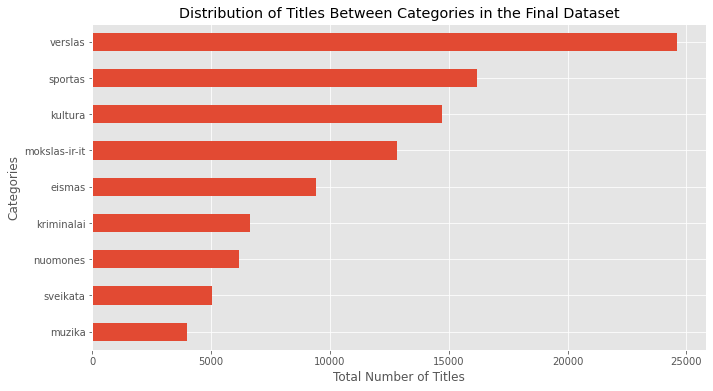

In [32]:
plt.style.use("ggplot")
plt.figure(figsize=(11, 6))
pur_df["category"].value_counts().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Total Number of Titles")
plt.ylabel("Categories")
plt.title("Distribution of Titles Between Categories in the Final Dataset")
plt.show()

##### Final dataset has 99499 titles, 25 thousands or 1/4 of them are placed in 'verslas' category.

##### Other popular categories are 'sportas' and 'kultura' having around 15 000 titles each.

##### Least common categories are 'muzika' and 'sveikata' having around 5 000 titles each.

In [37]:
pur_df[["title_length", "word_count"]].describe()

,title_length,word_count
count,99499.000000,99499.000000
mean,74.690308,9.785938
std,19.749225,2.753795
min,4.000000,1.000000
25%,61.000000,8.000000
50%,74.000000,10.000000
75%,87.000000,12.000000
max,250.000000,34.000000


##### Average length of all titles is 75 characters and there are 10 words on average in them.

In [38]:
# Calculating mean length of a title between categories
s_tl = pur_df.groupby("category")["title_length"].mean().sort_index()
s_tl

category
eismas           78.086892
kriminalai       69.431251
kultura          79.314775
mokslas-ir-it    71.640631
muzika           82.877070
nuomones         61.957412
sportas          72.736631
sveikata         85.300756
verslas          74.597740
Name: title_length, dtype: float64

In [39]:
# Calculating mean number of words in a title between categories
s_wc = pur_df.groupby("category")["word_count"].mean().sort_index()
s_wc

category
eismas           10.037604
kriminalai        9.068976
kultura          10.171714
mokslas-ir-it     9.352027
muzika           11.093327
nuomones          8.132315
sportas           9.380773
sveikata         11.335788
verslas          10.028692
Name: word_count, dtype: float64

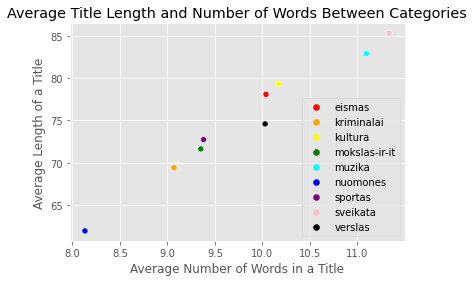

In [40]:
sns.set_palette(["red", "orange", "yellow", "green", "cyan", "blue", "purple", "pink", "black"])
sns.scatterplot(x=s_wc, y=s_tl, hue=s_wc.index)
plt.legend(loc=4)
plt.xlabel("Average Number of Words in a Title")
plt.ylabel("Average Length of a Title")
plt.title("Average Title Length and Number of Words Between Categories")
plt.show()

##### Linear trend can be seen between average length of a title and number of words in it.

##### The largest average titles are in categories 'sveikata' and 'muzika' while the shortest are in 'nuomones' category.

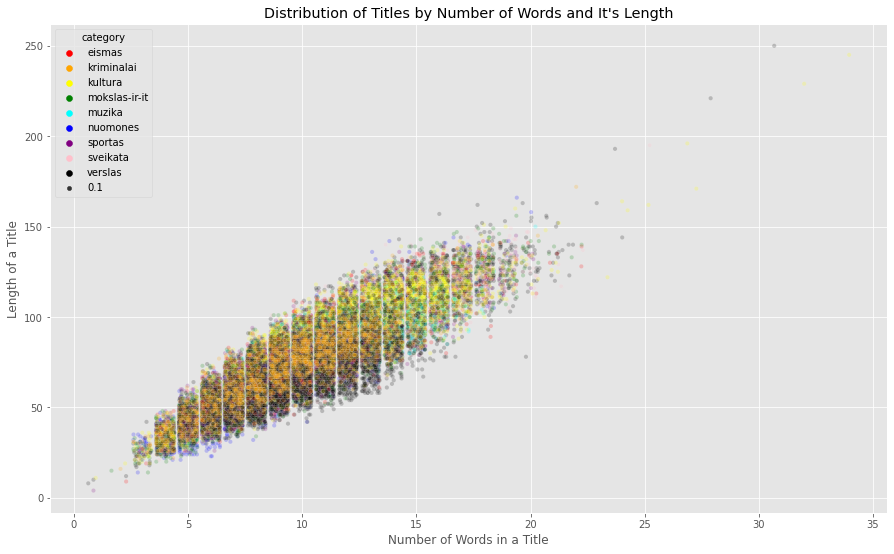

In [44]:
plt.figure(figsize=(15, 9))
np.random.seed(420)
sns.scatterplot(x=pur_df["word_count"]+np.random.uniform(low=-0.4, high=0.4, size=pur_df.shape[0]),
                y=pur_df["title_length"], hue=pur_df["category"], alpha=0.2, size=0.1)
plt.xlabel("Number of Words in a Title")
plt.ylabel("Length of a Title")
plt.title("Distribution of Titles by Number of Words and It's Length")
plt.show()

##### Linear trend can be seen again.
##### Majority of titles have between 4 and 19 words and their length is between 25 and 140 characters.

In [47]:
# Calculating top 10 similar titles' distribution between categories for each category
stat_tab = pur_df[pur_df.columns[:-2]].groupby("category").sum().reset_index()

# Calculating total number of scores for each category
stat_tab["total"] = stat_tab[categories_to_keep].sum(axis=1)
stat_tab

,category,verslas,sportas,kultura,mokslas-ir-it,nuomones,eismas,kriminalai,sveikata,muzika,total
0,eismas,13009,3551,2138,3592,2598,58324,9630,1101,197,94140
1,kriminalai,5567,3299,2418,1976,3048,7839,40622,1153,188,66110
2,kultura,6866,8973,97231,6849,12236,2905,3957,1586,6677,147280
3,mokslas-ir-it,13852,5565,7790,77507,6259,4410,3532,8441,674,128030
4,muzika,504,2642,7825,672,1028,278,359,115,26437,39860
5,nuomones,7400,6779,7605,4104,27688,2302,3355,1758,529,61520
6,sportas,6863,124947,6718,3729,8725,3688,4146,1347,1587,161750
7,sveikata,4579,1777,1614,8408,2535,1249,1779,28189,110,50240
8,verslas,174015,9512,7867,14761,11548,14586,8411,4758,602,246060


In [48]:
# Converting scores to percentages within each category
stat_tab[categories_to_keep] = stat_tab.apply(lambda x: x[categories_to_keep]/x["total"]*100, axis=1).apply(lambda x: x.round(1))
stat_tab = stat_tab.set_index("category").drop("total", axis=1)
stat_tab

,verslas,sportas,kultura,mokslas-ir-it,nuomones,eismas,kriminalai,sveikata,muzika
category,,,,,,,,,
eismas,13.8,3.8,2.3,3.8,2.8,62.0,10.2,1.2,0.2
kriminalai,8.4,5.0,3.7,3.0,4.6,11.9,61.4,1.7,0.3
kultura,4.7,6.1,66.0,4.7,8.3,2.0,2.7,1.1,4.5
mokslas-ir-it,10.8,4.3,6.1,60.5,4.9,3.4,2.8,6.6,0.5
muzika,1.3,6.6,19.6,1.7,2.6,0.7,0.9,0.3,66.3
nuomones,12.0,11.0,12.4,6.7,45.0,3.7,5.5,2.9,0.9
sportas,4.2,77.2,4.2,2.3,5.4,2.3,2.6,0.8,1.0
sveikata,9.1,3.5,3.2,16.7,5.0,2.5,3.5,56.1,0.2
verslas,70.7,3.9,3.2,6.0,4.7,5.9,3.4,1.9,0.2


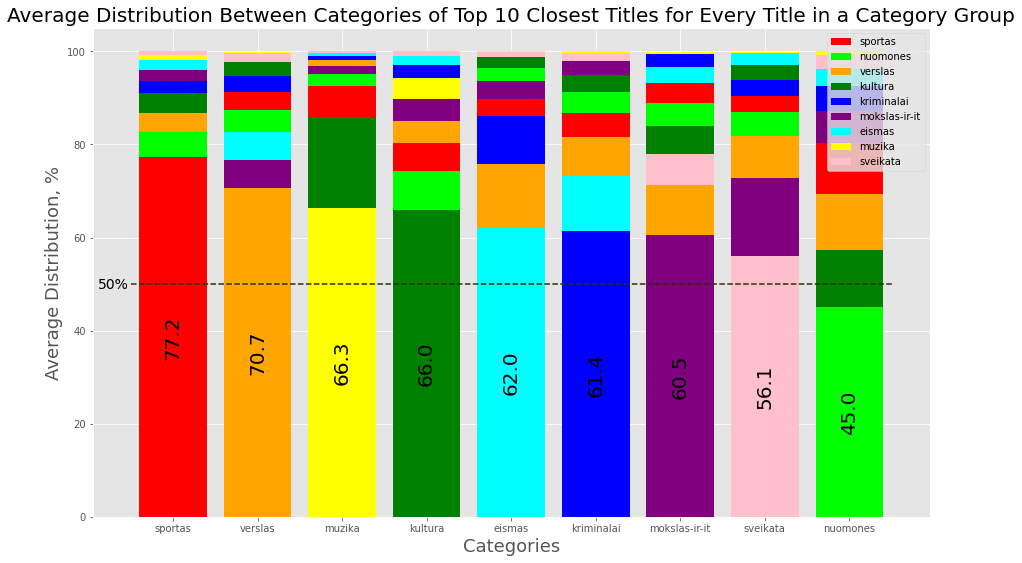

In [51]:
plt.figure(figsize=(15, 9))

c_map = sns.color_palette(["red", "orange", "yellow", "green", "cyan", "blue", "purple", "pink", "lime"])
ordered_cols = [r[0] for r in sorted([(cat, stat_tab.loc[cat, cat]) for cat in categories_to_keep],
                                     key=lambda x: x[1], reverse=True)]
cat_color = dict(zip(ordered_cols, [i[0] for i in enumerate(ordered_cols)]))


for cat in ordered_cols:
    row = stat_tab.loc[cat, :].sort_values(ascending=False)
    idxs = row.index
    vals = row.values
    for i, tup in enumerate(zip(idxs, vals)):
        plt.bar(x=cat, height=tup[1], bottom=sum(vals[:i]), label=tup[0], color=c_map[cat_color.get(tup[0])])
        if not i:
            plt.text(s=str(tup[1]), x=tup[0], y=tup[1]/2, rotation=90, fontsize=20, ha="center", va="center")


plt.legend(stat_tab.loc[ordered_cols[0], :].sort_values(ascending=False).index, loc=1)
plt.hlines(y=50, xmin=-0.5, xmax=len(ordered_cols)-0.5, colors=[0.15, 0.2, 0], linestyle="dashed")
plt.text(s="50%", x=-0.7, y =50, ha="center", va="center", fontsize=14)
plt.title("Average Distribution Between Categories of Top 10 Closest Titles for Every Title in a Category Group", fontdict={"size":20})
plt.xlabel("Categories", fontdict={"size":18})
plt.ylabel("Average Distribution, %", fontdict={"size":18})
plt.show()

##### It can be seen that titles from 'sportas' category should be the easiest to distinguish from the others - more than 3/4 of all titles from this category had a title from the same category very similar to itself.
##### 'verslas' category has the second highest score here even though it is noticeably mixed up with 'eismas', 'mokslas-it-it', 'sveikata'  and 'nuomones' categories. The reason for it may be the fact that this category has a huge number of titles in the dataset - around 25 %, so it was less difficult for titles to find a similar one from the same category.
##### 'muzika' category is mixed up with 'kultura' the most and the later tend to be similar with 'nuomones' category.
##### 'eismas' is mixed up with 'kriminalai' - it may be due to the fact that incidents often involve traffic.
##### Titles from 'sveikata' category find similarity with titles from 'mokslas-ir-it' the most.
##### The chart suggests that the hardest task will be to distinguish titles from 'nuomones' category because it mixes up with other categories the most. This may be the truth because titles from this category can be on many topics and the reason for them to be classified as 'nuomones' is that it represents someone's opinion.

# 3. Model

### Finding useful features for the model

In [52]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
import scipy

In [53]:
def split_data(df, X_title_col, X_num_cols, target_col, use_oversampler):
    """Split data into train and test datasets"""
    if not X_num_cols:  # Only 'title' feature should be in the final X datasets
        # Splitting data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(df[X_title_col], df[target_col], test_size=0.3, random_state=420)
    
    else:  # Numerical features should be included in the final X datasets
        # Splitting data into train and test sets
        X_cols = X_num_cols.copy()
        X_cols.append(X_title_col)
        X_train, X_test, y_train, y_test = train_test_split(df[X_cols], df[target_col], test_size=0.3, random_state=420)
    
    # Checking if oversampling should be used
    if use_oversampler == "RandOv":
        ovs = RandomOverSampler(random_state=420)
        X_train, y_train = ovs.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test

##### Splitting data into training and testing feature sets and their target labels, in order for it to be in a suitable format for the model and to have 'unseen' data to test the model with.
##### Oversampling increases the amount of total titles in the dataset for smaller categories so that the share for each of them would be equal.

In [54]:
def vectorize_titles(X_train, X_test, X_title_col, X_num_cols):
    """Convert titles to vectors"""
    vectorizer = CountVectorizer()
    
    if not X_num_cols:  # X datasets contain only 'title' feature
        X_train_vect = vectorizer.fit_transform(X_train.values)
        X_test_vect = vectorizer.transform(X_test.values)
    
    else:  # X datasets contain more than one feature
        X_train_vect = vectorizer.fit_transform(X_train[X_title_col].values)
        X_test_vect = vectorizer.transform(X_test[X_title_col].values)
    
    return X_train_vect, X_test_vect

##### Processing titles from text to numeric data - vectors, so it could be used in the model.

In [55]:
def scale_features(X_train, X_test):
    """Scale numerical features"""
    sc = StandardScaler()
    
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.transform(X_test)
    
    return X_train_scaled, X_test_scaled

##### Scaling numeric features helps the model to better fit the data.

In [56]:
def prepare_data(df, X_title_col, X_scale_cols, X_non_scale_cols, target_col, use_oversampler):
    """Preparing data for model"""
    # Checking if there are more features in X datasets excluding 'title'
    X_num_cols = X_scale_cols.copy()
    X_num_cols += X_non_scale_cols
    
    # Splitting data into train and test sets
    X_train, X_test, y_train, y_test = split_data(df, X_title_col, X_num_cols, target_col, use_oversampler)
    
    # Vectorizing titles
    X_train_vect, X_test_vect = vectorize_titles(X_train, X_test, X_title_col, X_num_cols)
    
    if X_scale_cols:  # Scalable features should be included in the final X datasets
        # Scaling numerical features
        X_train_scaled, X_test_scaled = scale_features(X_train[X_scale_cols], X_test[X_scale_cols])
        
        # Combining vectorized titles and scaled features
        X_train_final = scipy.sparse.hstack([X_train_vect, X_train_scaled])
        X_test_final = scipy.sparse.hstack([X_test_vect, X_test_scaled])
        
    else:  # No scalable features the X datasets
        X_train_final, X_test_final = X_train_vect, X_test_vect
    
    if X_non_scale_cols:  # Additional numerical features should be included in the final X datasets
        X_train_final = scipy.sparse.hstack([X_train_final, X_train[X_non_scale_cols]])
        X_test_final = scipy.sparse.hstack([X_test_final, X_test[X_non_scale_cols]])
    
    # Converting target labels from strings to numbers
    cat_to_label = dict(zip(categories_to_keep, [i[0] for i in enumerate(categories_to_keep)]))
    y_train = np.array(y_train.map(cat_to_label).values)
    y_test = np.array(y_test.map(cat_to_label).values)
    
    return X_train_final, X_test_final, y_train, y_test

##### Using previous 3 functions to convert the data into suitable format for the model.

In [57]:
def model_and_stats(df, X_title_col="title", X_scale_cols: list = [], X_non_scale_cols: list = [], target_col="category",
                   use_oversampler: ["None", "RandOv"] = "None"):
    """Train model and get results"""
    # Getting data
    X_train, X_test, y_train, y_test = prepare_data(df, X_title_col, X_scale_cols, X_non_scale_cols, target_col, use_oversampler)
    
    # Creating and training the model
    lr = LogisticRegression(multi_class="ovr", random_state=420, max_iter=500)
    lr.fit(X_train, y_train)
    
    # Getting predictions and calculating model performance results
    y_pred = lr.predict(X_test)
    train_acc = lr.score(X_train, y_train)
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(f"Model's accuracy on training data: {train_acc:.5f}")
    print(f"Model's accuracy on test data: {test_acc:.5f}")
    print(f"Model's f1_score: {test_f1:.5f}")

##### Getting data, creating and training the model, calculating results. These functions were created to help compare the performance of  models trained with different data.

#### Now for better understanding the steps of training the benchmark model will be explained

In [58]:
# Everytime data will be split into 70% training and 30% testing datasets.
# The same (random_state) will be used for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(pur_df["title"], pur_df["category"], test_size=0.3,
                                                    random_state=420)

In [59]:
X_train.size, y_train.size, X_test.size, y_test.size

(69649, 69649, 29850, 29850)

##### Train set has 69649 titles and test has 29850 titles from every category.

In [61]:
# 10% of titles ditribution between categories in the train dataset
y_train.value_counts()/7  # dividing by 7 because train set is 7 parts of the whole dataset

verslas          2466.285714
sportas          1620.428571
kultura          1462.857143
mokslas-ir-it    1282.428571
eismas            944.142857
kriminalai        665.714286
nuomones          611.285714
sveikata          494.428571
muzika            402.285714
Name: category, dtype: float64

In [62]:
# 10% of titles ditribution between categories in the test dataset
y_test.value_counts()/3  # dividing by 3 because test set is 3 parts of the whole dataset

verslas          2447.333333
sportas          1610.666667
kultura          1496.000000
mokslas-ir-it    1275.333333
eismas            935.000000
kriminalai        650.333333
nuomones          624.333333
sveikata          521.000000
muzika            390.000000
Name: category, dtype: float64

In [63]:
(y_train.value_counts()/7) / (y_test.value_counts()/3)

verslas          1.007744
sportas          1.006061
kultura          0.977846
mokslas-ir-it    1.005563
eismas           1.009778
kriminalai       1.023651
nuomones         0.979102
sveikata         0.948999
muzika           1.031502
Name: category, dtype: float64

##### Both datasets have very similar distribution of titles between categories - scores are near 1.

In [64]:
# This dictionary will be used to encode categories
cat_to_label = dict(zip(categories_to_keep, [i[0] for i in enumerate(categories_to_keep)]))
cat_to_label

{'verslas': 0,
 'sportas': 1,
 'kultura': 2,
 'mokslas-ir-it': 3,
 'nuomones': 4,
 'eismas': 5,
 'kriminalai': 6,
 'sveikata': 7,
 'muzika': 8}

In [65]:
# Encoding categories
y_train = np.array(y_train.map(cat_to_label).values)
y_test = np.array(y_test.map(cat_to_label).values)

In [66]:
y_train

array([5, 3, 5, ..., 5, 8, 0], dtype=int64)

In [67]:
# Creating count vectorizer and converting titles in the train dataset to vectors
vectorizer = CountVectorizer()

X_train_vect = vectorizer.fit_transform(X_train.values)

In [68]:
X_train_vect

<69649x80012 sparse matrix of type '<class 'numpy.int64'>'
	with 658980 stored elements in Compressed Sparse Row format>

In [69]:
vectorizer.get_feature_names_out()

array(['000', '007', '02', ..., 'zyniai', 'zyniu', 'zyrkovo'],
      dtype=object)

##### The title column was converted to 80012 columns for each set of characters, for example '000' or 'zyniai', that was found in titles.

In [70]:
# Converting titles in the test dataset to vectors
X_test_vect = vectorizer.transform(X_test)

In [71]:
X_test_vect

<29850x80012 sparse matrix of type '<class 'numpy.int64'>'
	with 265559 stored elements in Compressed Sparse Row format>

In [72]:
# Creating model - multiclass logistic regression
# (random_state) will be used for reproducibility and (max_iter) is increased, in order for the model to have enough iterations
# to fit the data
lr = LogisticRegression(multi_class="ovr", random_state=420, max_iter=500)

In [73]:
# Training the model with train dataset
lr.fit(X_train_vect, y_train)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=420)

In [74]:
# Using the model to predict the categories for titles in the test dataset
y_pred = lr.predict(X_test_vect)
y_pred

array([0, 4, 5, ..., 2, 1, 3], dtype=int64)

In [75]:
y_test

array([0, 4, 5, ..., 2, 1, 3], dtype=int64)

##### It is visible that first 3 and last 3 titles were categorized correctly but scoring metrics should be used to get the model's performance

In [76]:
# Calculating the accuracy score that model reaches then predicting categories of titles from train dataset
lr.score(X_train_vect, y_train)

0.979339258280808

In [77]:
# Calculating the accuracy score that model reaches then predicting categories of titles from test dataset
accuracy_score(y_test, y_pred)

0.8705192629815746

In [78]:
# Calculating the f1 score that model reaches then predicting categories of titles from test dataset
f1_score(y_test, y_pred, average="weighted")

0.8701074755147508

##### Benchmark model has 0.87052 accuracy and 0.87011 f1 score - the higher the better

##### Using the functions defined earlier to get the performance results of models

In [79]:
# Benchmark model
model_and_stats(pur_df)

Model's accuracy on training data: 0.97934
Model's accuracy on test data: 0.87052
Model's f1_score: 0.87011


##### It can be seen that results are the same - functions work! Now models will be trained with different features.

In [80]:
# Adding top 10 titles distribution between categories, using RandomOverSampler
model_and_stats(pur_df, X_scale_cols=categories_to_keep, use_oversampler="RandOv")

Model's accuracy on training data: 0.98895
Model's accuracy on test data: 0.86868
Model's f1_score: 0.86893


In [81]:
# Adding title length and word count, using RandomOverSampler
model_and_stats(pur_df, X_scale_cols=["title_length", "word_count"], use_oversampler="RandOv")

Model's accuracy on training data: 0.99159
Model's accuracy on test data: 0.87300
Model's f1_score: 0.87344


In [82]:
# Adding top 10 titles distribution between categories, title length and word count, using RandomOverSampler
model_and_stats(pur_df, X_scale_cols=list(pur_df.columns[2:]), use_oversampler="RandOv")

Model's accuracy on training data: 0.98907
Model's accuracy on test data: 0.87045
Model's f1_score: 0.87067


##### The best results are reached when using features title, title length, word count and random over sampler:
- 0.87300 accuracy score
- 0.87344 f1 score

### Pipeline and GridSearchCV

In [83]:
# Splitting the data using only the best features
X_train, X_test, y_train, y_test = split_data(pur_df, "title", ["title_length", "word_count"], "category", "RandOv")

In [84]:
def return_title_column(X):
    """Returns column 'title'"""
    return X["title"]

In [85]:
def return_numeric_columns(X):
    """Returns columns 'title_length' and 'word_count'"""
    return X[["title_length", "word_count"]]

In [86]:
# Two functions above will be used in the pipeline to be able to transform text and numerical data differently but they need
# to have fit and fit_transform methods. Function transformer change them for this purpose.
get_text_data = FunctionTransformer(return_title_column, validate=False)
get_numeric_data = FunctionTransformer(return_numeric_columns, validate=False)

In [87]:
# Using feature union to be able to transform text and numerical data differently and then combine them together in the pipeline
process_and_join_features = FeatureUnion(transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('scaler', StandardScaler())  # Scaling numerical data ('title_length', 'word_count') with standard scaler
                ])),
                ('text_features', Pipeline([
                    ("selector", get_text_data),
                    ("vectorizer", CountVectorizer())  # Converting text data ('title') to vectors
                ]))])

In [88]:
# Joining all steps - from data transformation to model creation - in one object: pipeline
pipe = Pipeline([
        ('union', process_and_join_features),
        ('lr', LogisticRegression(multi_class="ovr", random_state=420, max_iter=500))
    ])

In [92]:
# Defining parameters that GridSerchCV should try out and find the best ones for the model
params = {
    "union__text_features__vectorizer__ngram_range": [(1, 1), (1, 2), (1, 3), (2, 3)],
    "union__text_features__vectorizer__max_df": [0.3, 0.1, 0.01, 0.005],
    "lr__penalty": ["l2", "none"]
}

In [93]:
# Creating GridSearchCV object, using 5-fold cross-validation and accuracy as a score metric
gs = GridSearchCV(estimator=pipe, param_grid=params, scoring="accuracy", cv=5, verbose=3)

In [94]:
# Training GridSeachCV object
# !TAKES A FEW HOURS! Set 'proceed_gs = True' if you want to calculate the results from the start.
proceed_gs = False
if proceed_gs:
    gs.fit(X_train, y_train)

In [95]:
if proceed_gs:
    gs.best_params_

In [97]:
if proceed_gs:
    gs.best_score_

##### Best results are achieved by using:
- CountVectorizer:
    - ngram_range = (1, 2)
    - max_df = 0.3
- LogisticRegression:
    - penalty = 'l2'

### Creating and training a model with the best parameters

In [98]:
process_and_join_features = FeatureUnion(transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('scaler', StandardScaler())
                ])),
                ('text_features', Pipeline([
                    ("selector", get_text_data),
                    ("vectorizer", CountVectorizer(ngram_range=(1, 2), max_df=0.3))  # Setting ngram_range=(1, 2) and max_df=0.3
                ]))])

In [99]:
pipe = Pipeline([
        ('union', process_and_join_features),
        ('lr', LogisticRegression(multi_class="ovr", random_state=420, max_iter=500)) # penalty='l2' is default, no need to specify
    ])

In [100]:
# Training the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function return_numeric_columns at 0x000001F2497E8F70>)),
                                                                 ('scaler',
                                                                  StandardScaler())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function return_title_column at 0x000001F2497E8C10>)),
                                                                 ('vectorizer',
                                                                  CountVectorizer(max_df=0.3,
                                                

In [101]:
# Predicting categories for titles in the test dataset
y_pred = pipe.predict(X_test)

In [102]:
pipe.score(X_train, y_train)

0.9994722479662239

In [103]:
accuracy_score(y_test, y_pred)

0.8748408710217755

In [104]:
f1_score(y_test, y_pred, average="weighted")

0.8749046113059135

##### Comparing final and benchmark models
- 87.484 % vs. 87.052 %: accuracy score increased by 0.432 %
- 87.490 % vs. 87.011 %: f1 score increased by 0.479 %

In [105]:
# Saving final model locally
with open("../FlaskApp/model.pkl", "wb") as file:
    pickle.dump(pipe, file)

## Final Notes

In [28]:
# Calculating how many titles were asigned to different categories
# Getting all titles from categories in (categories_to_keep) list
t = df_cat[df_cat["category"].isin(categories_to_keep)].copy()


# Finding combinations of categories from titles that were calssified in multiple categories
t_c_d = ["+".join(sorted(list(v))) for v in t[t.duplicated("title", keep=False)]\
         .groupby("title")["category"].unique().values if len(v) > 1]

In [29]:
# Calculating the frequencies of multi-categories combinations
Counter(t_c_d), print(len(t_c_d))

3911


(Counter({'mokslas-ir-it+verslas': 2763,
          'kultura+muzika': 235,
          'eismas+verslas': 849,
          'sportas+verslas': 4,
          'eismas+mokslas-ir-it+verslas': 2,
          'mokslas-ir-it+sveikata+verslas': 4,
          'kultura+verslas': 7,
          'nuomones+verslas': 13,
          'kriminalai+verslas': 15,
          'kriminalai+sportas': 2,
          'sveikata+verslas': 12,
          'mokslas-ir-it+sportas+verslas': 1,
          'kriminalai+kultura': 1,
          'eismas+kriminalai': 3}),
 None)

##### 3911 titles were asigned to multiple categories, most frequently:
- 'mokslas-ir-it' and 'verslas'
- 'eismas' and 'verslas'
- 'kultura' and 'muzika'

##### 3911 out of 99499 or almost 4 % of titles in the final datset were previously classified in multiple categories. This shows that the task to assign a title to only one category isn't that easy even for the authors.